In [1]:
#https://github.com/monocongo/climate_learn
import glob

import netCDF4
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as c
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.cluster.vq import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nc_time_axis
import cftime

from scipy.spatial import distance
# from skimage import measure

xr.set_options(display_style='text')

from eofs.xarray import Eof

In [2]:
from packages import *
import EOFsfunction 
# import weighted_SM_average

In [3]:
import cartopy as cart
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

### Get a list of all files available in folders for CLM5 model simulations

In [4]:
CLM5_Exp1 = glob.glob("/scratch/leaf/SP-MIP/CLM5_experiment_1*")
CLM5_Exp2 = glob.glob("/scratch/leaf/SP-MIP/CLM5_experiment_2*")
CLM5_Exp3 = glob.glob("/scratch/leaf/SP-MIP/CLM5_experiment_3*")
CLM5_Exp4a = glob.glob("/scratch/leaf/SP-MIP/CLM5_experiment_4a*")
CLM5_Exp4b = glob.glob("/scratch/leaf/SP-MIP/CLM5_experiment_4b*")
CLM5_Exp4c = glob.glob("/scratch/leaf/SP-MIP/CLM5_experiment_4c*")
CLM5_Exp4d = glob.glob("/scratch/leaf/SP-MIP/CLM5_experiment_4d*")

us_lat_bounds = (24.0, 50.0)
us_lon_bounds = (360-126.0, 360-66.0)
landmask = xr.open_mfdataset(CLM5_Exp1).sel(lat=slice(*us_lat_bounds), lon=slice(*us_lon_bounds)).landmask

data_CLM5_Exp1 = xr.open_mfdataset(CLM5_Exp1).sel(lat=slice(*us_lat_bounds), lon=slice(*us_lon_bounds))*landmask
data_CLM5_Exp2 = xr.open_mfdataset(CLM5_Exp2).sel(lat=slice(*us_lat_bounds), lon=slice(*us_lon_bounds))*landmask
data_CLM5_Exp3 = xr.open_mfdataset(CLM5_Exp3).sel(lat=slice(*us_lat_bounds), lon=slice(*us_lon_bounds))*landmask
data_CLM5_Exp4a = xr.open_mfdataset(CLM5_Exp4a).sel(lat=slice(*us_lat_bounds), lon=slice(*us_lon_bounds))*landmask
data_CLM5_Exp4b = xr.open_mfdataset(CLM5_Exp4b).sel(lat=slice(*us_lat_bounds), lon=slice(*us_lon_bounds))*landmask
data_CLM5_Exp4c = xr.open_mfdataset(CLM5_Exp4c).sel(lat=slice(*us_lat_bounds), lon=slice(*us_lon_bounds))*landmask
data_CLM5_Exp4d = xr.open_mfdataset(CLM5_Exp4d).sel(lat=slice(*us_lat_bounds), lon=slice(*us_lon_bounds))*landmask

In [5]:
data_CLM5_Exp1.landmask

<xarray.DataArray 'landmask' (time: 11315, lat: 52, lon: 120)>
dask.array<mul, shape=(11315, 52, 120), dtype=float32, chunksize=(365, 52, 120), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1980-01-02 00:00:00 ... 2011-01-01 00:00:00
  * lon      (lon) float32 234.2 234.8 235.2 235.8 ... 292.2 292.8 293.2 293.8
  * lat      (lat) float32 24.25 24.75 25.25 25.75 ... 48.25 48.75 49.25 49.75

In [6]:
lat = np.arange(data_CLM5_Exp1.lat.min(), data_CLM5_Exp1.lat.max(), 0.5)
lon = np.arange(data_CLM5_Exp1.lon.min(), data_CLM5_Exp1.lon.max(), 0.5)

# Experiment 1, 2, 3 CLM Model Runs

### Exp-1 Identical Soil Parameter Maps
- Global soil hydraulic parameter maps provided by SP-MIP

### Exp-2 Identical Soil Texture Maps
- Global soil texture maps provided by SP-MIP
- hydraulic parameters are derived by the modelling groups 

### Exp-3 Identical Soil Texture Maps
- The model is run with default soil paramters

In [7]:
#=========================== Computing the annual mean 
exp1_mrlsl_ = data_CLM5_Exp1.mrlsl.sel(levsoi=slice(0,12)).mean('levsoi').groupby('time.year').mean(dim="time").mean(dim="year")*0.3715504356225332
exp2_mrlsl_ = data_CLM5_Exp2.mrlsl.sel(levsoi=slice(0,12)).mean('levsoi').groupby('time.year').mean(dim="time").mean(dim="year")*0.3913808739185334
exp3_mrlsl_ = data_CLM5_Exp3.mrlsl.sel(levsoi=slice(0,12)).mean('levsoi').groupby('time.year').mean(dim="time").mean(dim="year")*0.38882259051005047

In [8]:
#=========================== Computing the Time series 
exp1_mrlsl_t = data_CLM5_Exp1.mrlsl.sel(levsoi=slice(0,12)).mean('levsoi').groupby('time.year').mean(dim="time").mean(dim=("lat","lon"))*0.3715504356225332
exp2_mrlsl_t = data_CLM5_Exp2.mrlsl.sel(levsoi=slice(0,12)).mean('levsoi').groupby('time.year').mean(dim="time").mean(dim=("lat","lon"))*0.3913808739185334
exp3_mrlsl_t = data_CLM5_Exp3.mrlsl.sel(levsoi=slice(0,12)).mean('levsoi').groupby('time.year').mean(dim="time").mean(dim=("lat","lon"))*0.38882259051005047

In [9]:
def make_contour_plot_(data_nc, ax_index, title):
    #=================== Choose the Multi-model ensemble (MME) and week1 (time index of 0)
    data, lons = add_cyclic_point(data_nc, coord=exp1_mrlsl_['lon'])

    #=================== Make a filled contour plot
    cs = ax[ax_index].contourf(lons, exp1_mrlsl_['lat'], data, transform=ccrs.PlateCarree(),
                               cmap='RdBu_r', extend='both')
    states = cfeature.NaturalEarthFeature(category='cultural',
                                      name='admin_1_states_provinces_lines',scale='50m',facecolor='none')
    ax[ax_index].add_feature(states, edgecolor='gray')
    ax[ax_index].set_title(title, fontweight='bold', fontsize=10, loc='left')
    ax[ax_index].set_title(f"[kgm$^{-2}$]", loc='right', fontweight='bold', size=10)

    #=================== Add coastlines
    ax[ax_index].coastlines()
    #ax[ax_index].gridlines(alpha=0.5)

    #=================== Define the xticks for longitude
    ax[ax_index].set_xticks(np.arange(-126, -66, 10), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    ax[ax_index].xaxis.set_major_formatter(lon_formatter)

    #=================== Define the yticks for latitude
    ax[ax_index].set_yticks(np.arange(24, 50, 5), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    ax[ax_index].yaxis.set_major_formatter(lat_formatter)

    ax[ax_index].add_feature(cfeature.BORDERS, linestyle='-')
    ax[ax_index].add_feature(cfeature.COASTLINE)

    return cs

# #===========================Average variance explained for experiment 4a-d modes
# EOFs14_aver_var_Explained = (100*var_fracs3[0]+100*var_fracs3[0]+100*var_fracs3[0]+100*var_fracs3[0])/4
# EOFs24_aver_var_Explained = (100*var_fracs3[1]+100*var_fracs3[1]+100*var_fracs3[1]+100*var_fracs3[1])/4

# #============================================EOF Time Series 
# def plot_eofs_over_time_(years, time_data, eof_labels, title, xlabel, ylabel):
#     plt.figure(figsize=(14,3))
#     for i in range(len(time_data)):
#         plt.plot(exp1_mrlsl_t.year, time_data, label=eof_labels[i], linewidth=3, linestyle='dashed', marker="o")
#     plt.xlabel(xlabel, fontweight='bold', fontsize=12)
#     plt.ylabel(ylabel, fontweight='bold', fontsize=12)
#     plt.title(title, fontweight='bold', loc='left', size=12)
#     plt.legend(loc="upper right", fontsize=8)
#     plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
#     plt.axhline(0, color='k')
#     plt.minorticks_on()
#     plt.grid(linestyle=':', linewidth=0.5, color='k')
#     plt.subplots_adjust(left=-0.19, right=0.8, top=0.8, bottom=0.1)
#     plt.show()
#     np.delete(eof_amplitudes[i],-1)

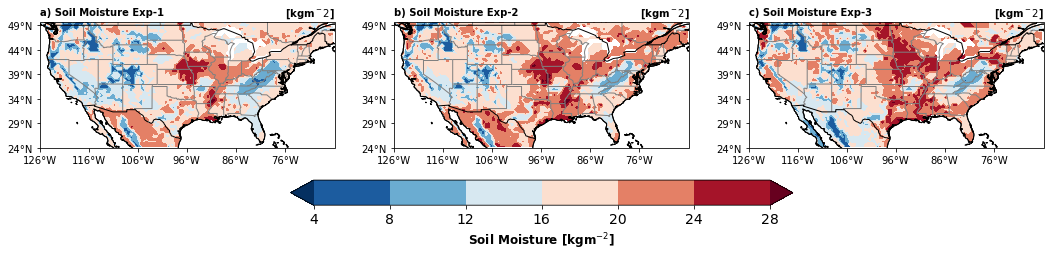

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[18,6], subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'wspace':.2, 'hspace':.22})

#============================================ EOF Spatial Correlation Maps 
cs1_ = make_contour_plot_(exp1_mrlsl_,  0, 'a) Soil Moisture Exp-1')
cs2_ = make_contour_plot_(exp2_mrlsl_,  1, 'b) Soil Moisture Exp-2')
cs3_ = make_contour_plot_(exp3_mrlsl_,  2, 'c) Soil Moisture Exp-3')


#======================== Create colorbar
cbar = plt.colorbar(cs1_, ax=ax.ravel().tolist(), orientation='horizontal', shrink=.5, extend='both', pad=0.099)
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Soil Moisture [kgm$^{-2}$]',fontweight='bold', fontsize=12)
# #cbar.set_ticks(np.linspace(eofs_corr3.min(), eofs_corr3.max(), 6))

In [11]:
# exp1_mrlsl_t.values.max()

In [12]:
#============================================EOF Time Series 
def plot_eofs_over_time_(time_data, eof_labels, title, xlabel, ylabel):
    plt.figure(figsize=(8,7))
    for i in range(len(time_data)):
        plt.plot(exp1_mrlsl_t.year.data, time_data[i], label=eof_labels[i], linewidth=3, linestyle='dashed', marker="o")
    plt.xlabel(xlabel, fontweight='bold', fontsize=12)
    plt.ylabel(ylabel, fontweight='bold', fontsize=12)
    plt.title(title, fontweight='bold', loc='center', size=12)
    plt.legend(loc="upper right", fontsize=8)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    #plt.axhline(0, color='k')
#     plt.ylim( 41,  48)
    plt.minorticks_on()
    plt.grid(linestyle=':', linewidth=0.5, color='k')
    plt.subplots_adjust(left=-0.19, right=0.8, top=0.8, bottom=0.1)
    plt.show()

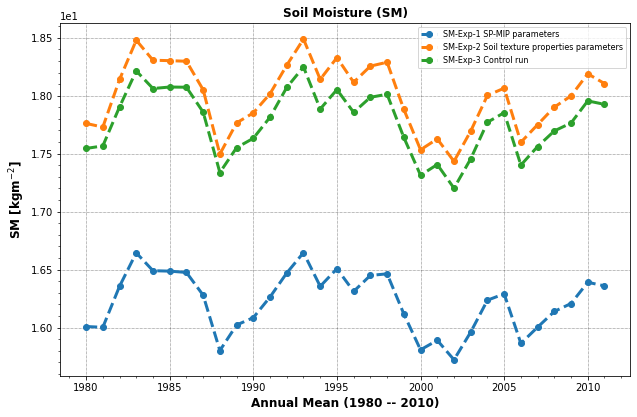

In [13]:
#============================================ Time Series 
years = np.arange(1980, 2011, 1)
time_data = [exp1_mrlsl_t.data, exp2_mrlsl_t.data, exp3_mrlsl_t.data]
eof_labels = ["SM-Exp-1 SP-MIP parameters", "SM-Exp-2 Soil texture properties parameters", "SM-Exp-3 Control run"]
title = "Soil Moisture (SM)"
xlabel = "Annual Mean (1980 -- 2010)"
ylabel = "SM [kgm$^{-2}$]"
plot_eofs_over_time_(time_data, eof_labels, title, xlabel, ylabel)

# Empirical Orthogonal Function Analysis 

In [14]:
#=========================== Computing the annual mean 
exp1_mrlsl = data_CLM5_Exp1.mrlsl.sel(levsoi=slice(0,12)).mean('levsoi').groupby('time.year').mean('time').isel()*0.3715504356225332
exp2_mrlsl = data_CLM5_Exp2.mrlsl.sel(levsoi=slice(0,12)).mean('levsoi').groupby('time.year').mean('time').isel()*0.3913808739185334
exp3_mrlsl = data_CLM5_Exp3.mrlsl.sel(levsoi=slice(0,12)).mean('levsoi').groupby('time.year').mean('time').isel()*0.38882259051005047

#=========================== Decomposing SPMIP soil moisture data experiment 1-3 
n_eof = 32 #number of EOFs considered
eofs1, pcs1, var_fracs1, lambdas1, eofs_corr1, eof_corrpcs1,reconstruction1 = EOFsfunction.Emp_Ortho_Funcs(exp1_mrlsl, n_eof)
eofs2, pcs2, var_fracs2, lambdas2, eofs_corr2, eof_corrpcs2,reconstruction2 = EOFsfunction.Emp_Ortho_Funcs(exp2_mrlsl, n_eof)
eofs3, pcs3, var_fracs3, lambdas3, eofs_corr3, eof_corrpcs3,reconstruction3 = EOFsfunction.Emp_Ortho_Funcs(exp3_mrlsl, n_eof)

....Checking Setting Weighting...
....Decomposing Modes of SPMIP Data...
...Correlating.....
....Checking Setting Weighting...
....Decomposing Modes of SPMIP Data...
...Correlating.....
....Checking Setting Weighting...
....Decomposing Modes of SPMIP Data...
...Correlating.....


In [15]:
lambdas1.shape 

(32,)

In [16]:
# n_eof = 5
# us_ds = us_ds.sel(lat=slice(*us_lat_bounds), lon=slice(*us_lon_bounds))
# # data_CLM5_Exp3_USA = data_CLM5_Exp3.sel(lon=slice(230.25, 299.75), lat=slice(20, 50))
# exp3_mrlsl = us_ds.mrlsl.sel(levsoi=slice(0,12)).mean('levsoi').groupby('time.year').mean('time').isel()
# eofs3, pcs3, var_fracs3, lambdas3, eofs_corr3, eof_corrpcs3,reconstruction3 = EOFsfunction.Emp_Ortho_Funcs(exp3_mrlsl, n_eof)

In [33]:
def make_contour_plot(eofs, var_fracs, ax_index, title):
    #=================== Choose the Multi-model ensemble (MME) and week1 (time index of 0)
    data, lons = add_cyclic_point(eofs, coord=exp1_mrlsl['lon'])

    #=================== Make a filled contour plot
    cs = ax[ax_index].contourf(lons, exp1_mrlsl['lat'], data, transform=ccrs.PlateCarree(),
                               cmap='RdBu_r', extend='both')
    states = cfeature.NaturalEarthFeature(category='cultural',
                                      name='admin_1_states_provinces_lines',scale='50m',facecolor='none')
    ax[ax_index].add_feature(states, edgecolor='gray')
    ax[ax_index].set_title(title, fontweight='bold', fontsize=10, loc='left')
    ax[ax_index].set_title(f"Expl. Var. {(var_fracs*100).round(2)}%", loc='right', fontweight='bold', size=10)

    #=================== Add coastlines
    ax[ax_index].coastlines()
    #ax[ax_index].gridlines(alpha=0.5)

    #=================== Define the xticks for longitude
    ax[ax_index].set_xticks(np.arange(-126, -66, 10), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    ax[ax_index].xaxis.set_major_formatter(lon_formatter)

    #=================== Define the yticks for latitude
    ax[ax_index].set_yticks(np.arange(24, 50, 5), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    ax[ax_index].yaxis.set_major_formatter(lat_formatter)

    ax[ax_index].add_feature(cfeature.BORDERS, linestyle='-')
    ax[ax_index].add_feature(cfeature.COASTLINE)
    ax[ax_index].add_feature(cfeature.OCEAN,color='lightgrey')

    return cs



# #===========================Average variance explained for experiment 4a-d modes
# EOFs14_aver_var_Explained = (100*var_fracs3[0]+100*var_fracs3[0]+100*var_fracs3[0]+100*var_fracs3[0])/4
# EOFs24_aver_var_Explained = (100*var_fracs3[1]+100*var_fracs3[1]+100*var_fracs3[1]+100*var_fracs3[1])/4

#============================================EOF Time Series 
def plot_eofs_over_time(years, eof_amplitudes, eof_labels, title, xlabel, ylabel):
    plt.figure(figsize=(14,3))
    for i in range(len(eof_amplitudes)):
        plt.plot(years, np.delete(eof_amplitudes[i],-1), label=eof_labels[i], linewidth=3, linestyle='dashed', marker="o")
    plt.xlabel(xlabel, fontweight='bold', fontsize=12)
    plt.ylabel(ylabel, fontweight='bold', fontsize=12)
    plt.title(title, fontweight='bold', loc='left', size=12)
    plt.legend(loc="upper right", fontsize=8)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.axhline(0, color='k')
    plt.minorticks_on()
    plt.grid(linestyle=':', linewidth=0.5, color='k')
    plt.subplots_adjust(left=-0.19, right=0.8, top=0.8, bottom=0.1)
    plt.show()
    

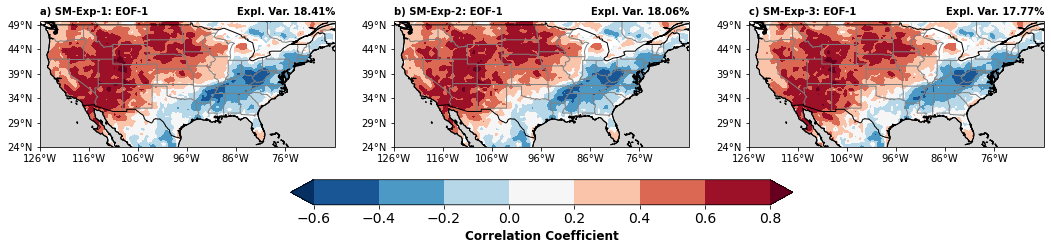

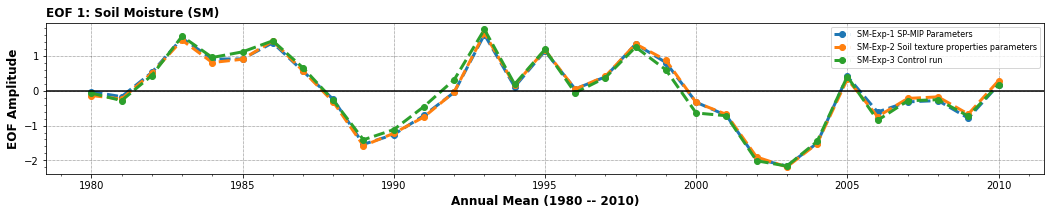

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[18,6], subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'wspace':.2, 'hspace':.22})

#============================================ EOF Spatial Correlation Maps 
cs1 = make_contour_plot(eofs_corr1[0,:,:], var_fracs1[0], 0, 'a) SM-Exp-1: EOF-1')
cs2 = make_contour_plot(eofs_corr2[0,:,:], var_fracs2[0], 1, 'b) SM-Exp-2: EOF-1')
cs3 = make_contour_plot(eofs_corr3[0,:,:], var_fracs3[0], 2, 'c) SM-Exp-3: EOF-1')
#======================== Create colorbar
cbar = plt.colorbar(cs1, ax=ax.ravel().tolist(), orientation='horizontal', shrink=.5, extend='both', pad=0.099)
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Correlation Coefficient',fontweight='bold', fontsize=12)

#============================================ EOF Time Series 
years = np.arange(1980, 2011, 1)
eof_amplitudes = [pcs1[:,0], pcs2[:,0], pcs3[:,0]]
eof_labels = ["SM-Exp-1 SP-MIP Parameters", "SM-Exp-2 Soil texture properties parameters", "SM-Exp-3 Control run"]
title = "EOF 1: Soil Moisture (SM)"
xlabel = "Annual Mean (1980 -- 2010)"
ylabel = "EOF Amplitude"
plot_eofs_over_time(years, eof_amplitudes, eof_labels, title, xlabel, ylabel)

fig.savefig('myplot.png')

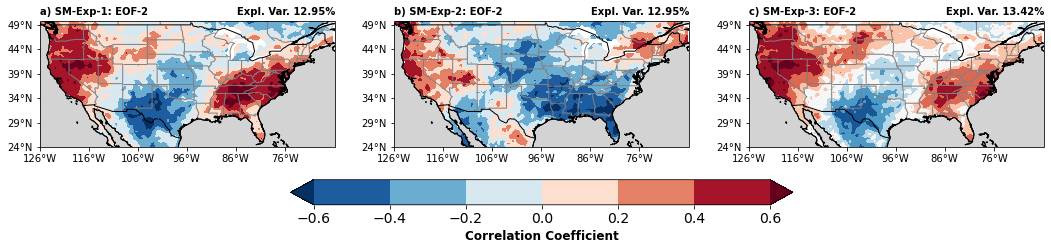

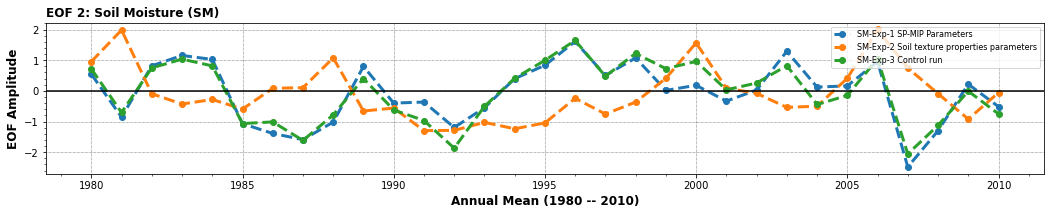

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[18,6], subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'wspace':.2, 'hspace':.22})

#============================================ EOF Spatial Correlation Maps 
cs1 = make_contour_plot(eofs_corr1[1,:,:], var_fracs1[1], 0, 'a) SM-Exp-1: EOF-2')
cs2 = make_contour_plot(eofs_corr2[1,:,:], var_fracs1[1], 1, 'b) SM-Exp-2: EOF-2')
cs3 = make_contour_plot(eofs_corr3[1,:,:], var_fracs3[1], 2, 'c) SM-Exp-3: EOF-2')
#======================== Create colorbar
cbar = plt.colorbar(cs1, ax=ax.ravel().tolist(), orientation='horizontal', shrink=.5, extend='both', pad=0.099)
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Correlation Coefficient',fontweight='bold', fontsize=12)

#============================================ EOF Time Series 
years = np.arange(1980, 2011, 1)
eof_amplitudes = [pcs1[:,1], pcs2[:,1], pcs3[:,1]]
eof_labels = ["SM-Exp-1 SP-MIP Parameters", "SM-Exp-2 Soil texture properties parameters", "SM-Exp-3 Control run"]
title = "EOF 2: Soil Moisture (SM)"
xlabel = "Annual Mean (1980 -- 2010)"
ylabel = "EOF Amplitude"
plot_eofs_over_time(years, eof_amplitudes, eof_labels, title, xlabel, ylabel)

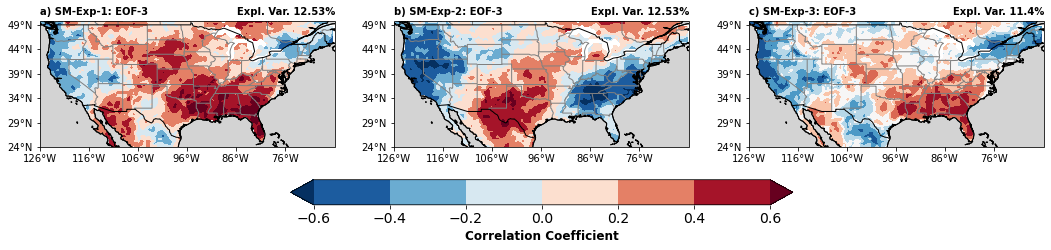

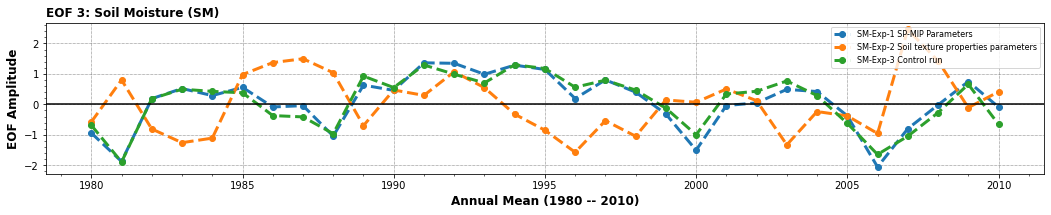

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[18,6], subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'wspace':.2, 'hspace':.22})

#============================================ EOF Spatial Correlation Maps 
cs1 = make_contour_plot(eofs_corr1[2,:,:], var_fracs1[2], 0, 'a) SM-Exp-1: EOF-3')
cs2 = make_contour_plot(eofs_corr2[2,:,:], var_fracs1[2], 1, 'b) SM-Exp-2: EOF-3')
cs3 = make_contour_plot(eofs_corr3[2,:,:], var_fracs3[2], 2, 'c) SM-Exp-3: EOF-3')
#======================== Create colorbar
cbar = plt.colorbar(cs1, ax=ax.ravel().tolist(), orientation='horizontal', shrink=.5, extend='both', pad=0.099)
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Correlation Coefficient',fontweight='bold', fontsize=12)

#============================================ EOF Time Series 
years = np.arange(1980, 2011, 1)
eof_amplitudes = [pcs1[:,2], pcs2[:,2], pcs3[:,2]]
eof_labels = ["SM-Exp-1 SP-MIP Parameters", "SM-Exp-2 Soil texture properties parameters", "SM-Exp-3 Control run"]
title = "EOF 3: Soil Moisture (SM)"
xlabel = "Annual Mean (1980 -- 2010)"
ylabel = "EOF Amplitude"
plot_eofs_over_time(years, eof_amplitudes, eof_labels, title, xlabel, ylabel)

## Experiment 4a, 4b, 4c, 4d CLM Model Runs

### Spatially Uniform soil Parameters
- Four model runs with spatially uniform soil parameters 
- Considered soil types: loamy sand, loam, and silt

In [21]:
#=========================== Computing the annual mean 
exp4a_mrlsl_ = data_CLM5_Exp4a.mrlsl.sel(levsoi=slice(0,12)).mean('levsoi').groupby('time.year').mean(dim="time").mean(dim="year")*0.27160229206085207
exp4b_mrlsl_ = data_CLM5_Exp4b.mrlsl.sel(levsoi=slice(0,12)).mean('levsoi').groupby('time.year').mean(dim="time").mean(dim="year")*0.3487188196182251
exp4c_mrlsl_ = data_CLM5_Exp4c.mrlsl.sel(levsoi=slice(0,12)).mean('levsoi').groupby('time.year').mean(dim="time").mean(dim="year")*0.4375002392133077
exp4d_mrlsl_ = data_CLM5_Exp4d.mrlsl.sel(levsoi=slice(0,12)).mean('levsoi').groupby('time.year').mean(dim="time").mean(dim="year")*0.5040913935502371

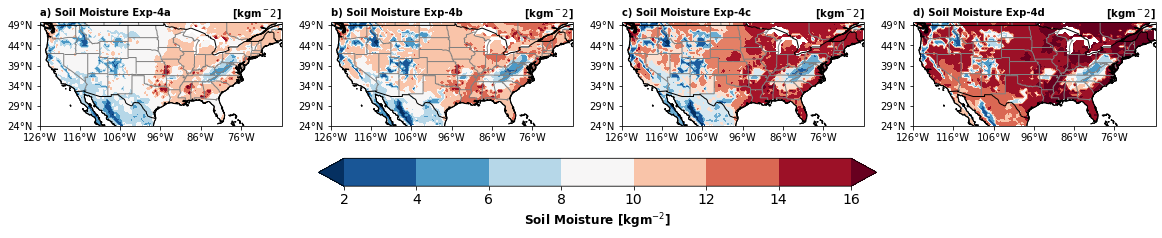

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=[20,6], subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'wspace':.2, 'hspace':.22})

#============================================ EOF Spatial Correlation Maps 
cs4a_ = make_contour_plot_(exp4a_mrlsl_ , 0, 'a) Soil Moisture Exp-4a')
cs4b_ = make_contour_plot_(exp4b_mrlsl_,  1, 'b) Soil Moisture Exp-4b')
cs4c_ = make_contour_plot_(exp4c_mrlsl_,  2, 'c) Soil Moisture Exp-4c')
cs4d_ = make_contour_plot_(exp4d_mrlsl_,  3, 'd) Soil Moisture Exp-4d')

#======================== Create colorbar
cbar = plt.colorbar(cs4a_, ax=ax.ravel().tolist(), orientation='horizontal', shrink=.5, extend='both', pad=0.099)
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Soil Moisture [kgm$^{-2}$]',fontweight='bold', fontsize=12)

# #cbar.set_ticks(np.linspace(eofs_corr3.min(), eofs_corr3.max(), 6))

In [23]:
#=========================== Computing the annual mean 
exp4a_mrlsl_t = data_CLM5_Exp4a.mrlsl.sel(levsoi=slice(0,12)).mean('levsoi').groupby('time.year').mean(dim="time").mean(dim=("lat","lon"))*0.27160229206085207
exp4b_mrlsl_t = data_CLM5_Exp4b.mrlsl.sel(levsoi=slice(0,12)).mean('levsoi').groupby('time.year').mean(dim="time").mean(dim=("lat","lon"))*0.3487188196182251
exp4c_mrlsl_t = data_CLM5_Exp4c.mrlsl.sel(levsoi=slice(0,12)).mean('levsoi').groupby('time.year').mean(dim="time").mean(dim=("lat","lon"))*0.4375002392133077
exp4d_mrlsl_t = data_CLM5_Exp4d.mrlsl.sel(levsoi=slice(0,12)).mean('levsoi').groupby('time.year').mean(dim="time").mean(dim=("lat","lon"))*0.5040913935502371

In [24]:
#============================================EOF Time Series 
def _plot_eofs_over_time_(time_data4, eof_labels, title, xlabel, ylabel):
    plt.figure(figsize=(8,7))
    for i in range(len(time_data4)):
        plt.plot(exp4a_mrlsl_t.year.data, time_data4[i], label=eof_labels[i], linewidth=3, linestyle='dashed', marker="o")
    plt.xlabel(xlabel, fontweight='bold', fontsize=12)
    plt.ylabel(ylabel, fontweight='bold', fontsize=12)
    plt.title(title, fontweight='bold', loc='center', size=12)
    plt.legend(loc="upper right", fontsize=8)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    #plt.axhline(0, color='k')
    #plt.ylim( 35,  43)
    plt.minorticks_on()
    plt.grid(linestyle=':', linewidth=0.5, color='k')
    plt.subplots_adjust(left=-0.19, right=0.8, top=0.8, bottom=0.1)
    plt.show()

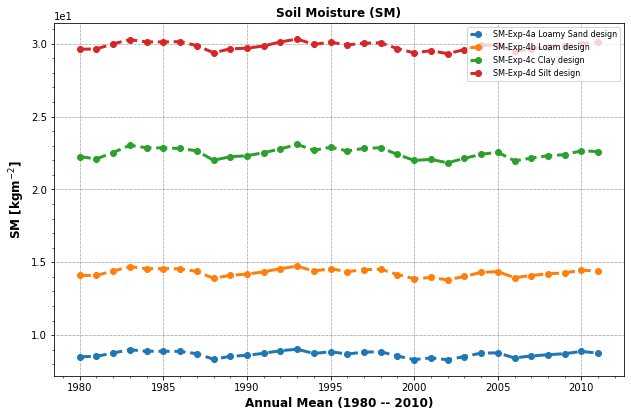

In [25]:
#============================================ Time Series 
time_data4 = [exp4a_mrlsl_t.data, exp4b_mrlsl_t.data, exp4c_mrlsl_t.data, exp4d_mrlsl_t.data]
eof_labels = ["SM-Exp-4a Loamy Sand design", "SM-Exp-4b Loam design", "SM-Exp-4c Clay design" , "SM-Exp-4d Silt design"]
title = "Soil Moisture (SM)"
xlabel = "Annual Mean (1980 -- 2010)"
ylabel = "SM [kgm$^{-2}$]"
_plot_eofs_over_time_(time_data4, eof_labels, title, xlabel, ylabel)

# Empirical Orthogonal Function Analysis 

In [26]:
#===========================Decomposing SPMIP soil moisture data experiment 4a-d 
n_eof = 20 #number of EOFs considered
exp4a_mrlsl = data_CLM5_Exp4a.mrlsl.sel(levsoi=slice(0,12)).mean('levsoi').groupby('time.year').mean('time').isel()*0.27160229206085207
exp4b_mrlsl = data_CLM5_Exp4b.mrlsl.sel(levsoi=slice(0,12)).mean('levsoi').groupby('time.year').mean('time').isel()*0.3487188196182251
exp4c_mrlsl = data_CLM5_Exp4c.mrlsl.sel(levsoi=slice(0,12)).mean('levsoi').groupby('time.year').mean('time').isel()*0.4375002392133077
exp4d_mrlsl = data_CLM5_Exp4d.mrlsl.sel(levsoi=slice(0,12)).mean('levsoi').groupby('time.year').mean('time').isel()*0.5040913935502371

eofs4a, pcs4a, var_fracs4a, lambdas4a, eofs_corr4a, eof_corrpcs4a, reconstruction4a = EOFsfunction.Emp_Ortho_Funcs(exp4a_mrlsl, n_eof)
eofs4b, pcs4b, var_fracs4b, lambdas4b, eofs_corr4b, eof_corrpcs4b, reconstruction4b = EOFsfunction.Emp_Ortho_Funcs(exp4b_mrlsl, n_eof)
eofs4c, pcs4c, var_fracs4c, lambdas4c, eofs_corr4c, eof_corrpcs4c, reconstruction4c = EOFsfunction.Emp_Ortho_Funcs(exp4c_mrlsl, n_eof)
eofs4d, pcs4d, var_fracs4d, lambdas4d, eofs_corr4d, eof_corrpcs4d, reconstruction4d = EOFsfunction.Emp_Ortho_Funcs(exp4d_mrlsl, n_eof)

....Checking Setting Weighting...
....Decomposing Modes of SPMIP Data...
...Correlating.....
....Checking Setting Weighting...
....Decomposing Modes of SPMIP Data...
...Correlating.....
....Checking Setting Weighting...
....Decomposing Modes of SPMIP Data...
...Correlating.....
....Checking Setting Weighting...
....Decomposing Modes of SPMIP Data...
...Correlating.....


In [27]:
#============================================EOF Time Series 
def _plot_eofs_over_time(years, eof_amplitudes, eof_labels, title, xlabel, ylabel):
    plt.figure(figsize=(10.5,3))
    for i in range(len(eof_amplitudes)):
        plt.plot(years, np.delete(eof_amplitudes[i],-1), label=eof_labels[i], linewidth=3, linestyle='dashed', marker="o")
    plt.xlabel(xlabel, fontweight='bold', fontsize=12)
    plt.ylabel(ylabel, fontweight='bold', fontsize=12)
    plt.title(title, fontweight='bold', loc='left', size=12)
    plt.legend(loc="upper right", fontsize=8)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.axhline(0, color='k')
    plt.minorticks_on()
    plt.grid(linestyle=':', linewidth=0.5, color='k')
    plt.subplots_adjust(left=.01, right=1.3, top=0.8, bottom=0.1)
    plt.show()

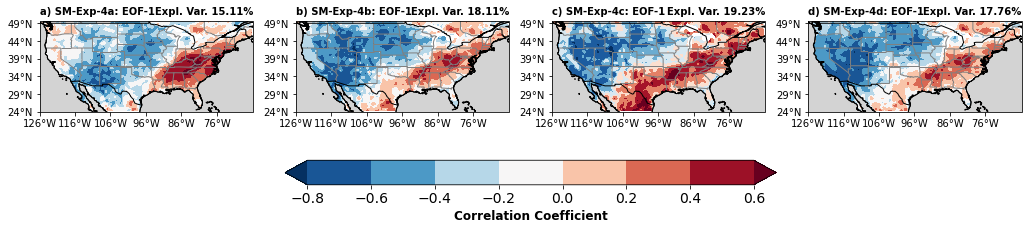

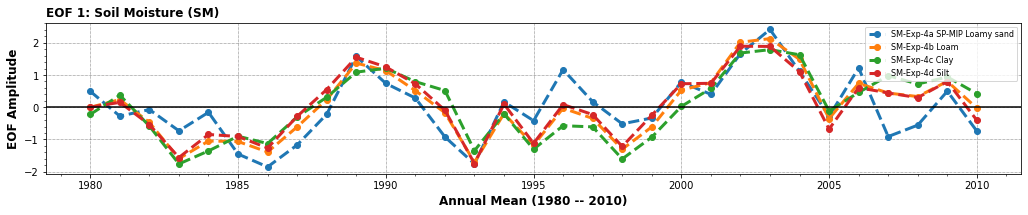

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=[17.6,9], subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'wspace':.2, 'hspace':.22})

#============================================ EOF Spatial Correlation Maps 
cs1 = make_contour_plot(eofs_corr4a[0,:,:], var_fracs4a[0], 0, 'a) SM-Exp-4a: EOF-1')
cs2 = make_contour_plot(eofs_corr4b[0,:,:], var_fracs4b[0], 1, 'b) SM-Exp-4b: EOF-1')
cs3 = make_contour_plot(eofs_corr4c[0,:,:], var_fracs4c[0], 2, 'c) SM-Exp-4c: EOF-1')
cs3 = make_contour_plot(eofs_corr4d[0,:,:], var_fracs4d[0], 3, 'd) SM-Exp-4d: EOF-1')
#======================== Create colorbar
cbar = plt.colorbar(cs1, ax=ax.ravel().tolist(), orientation='horizontal', shrink=.5, extend='both', pad=0.099)
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Correlation Coefficient',fontweight='bold', fontsize=12)
#cbar.set_ticks(np.linspace(eofs_corr3.min(), eofs_corr3.max(), 6))

#============================================ EOF Time Series 
years = np.arange(1980, 2011, 1)
eof_amplitudes = [pcs4a[:,0], pcs4b[:,0], pcs4c[:,0], pcs4d[:,0]]
eof_labels = ["SM-Exp-4a SP-MIP Loamy sand", "SM-Exp-4b Loam", "SM-Exp-4c Clay", "SM-Exp-4d Silt"]
title = "EOF 1: Soil Moisture (SM)"
xlabel = "Annual Mean (1980 -- 2010)"
ylabel = "EOF Amplitude"
_plot_eofs_over_time(years, eof_amplitudes, eof_labels, title, xlabel, ylabel)

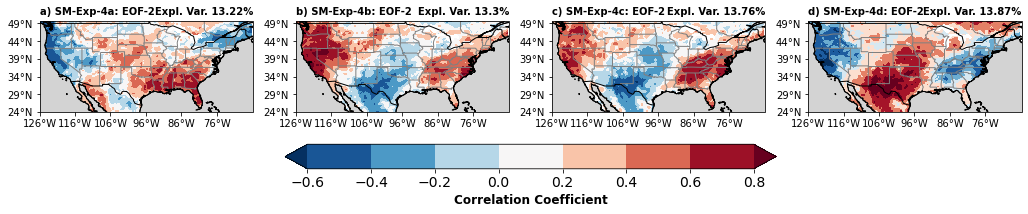

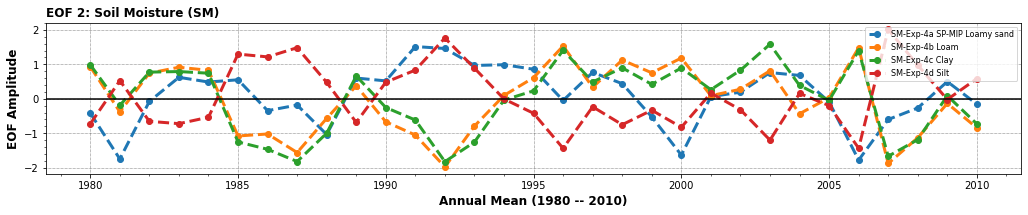

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=[17.6,6], subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'wspace':.2, 'hspace':.22})

#============================================ EOF Spatial Correlation Maps 
# fig.suptitle('Spatially Uniform Soil Paramters', y=0.65,fontweight='bold', fontsize=15)
cs4a_ = make_contour_plot(eofs_corr4a[1,:,:], var_fracs4a[1], 0, 'a) SM-Exp-4a: EOF-2')
cs4b_ = make_contour_plot(eofs_corr4b[1,:,:], var_fracs4b[1], 1, 'b) SM-Exp-4b: EOF-2')
cs4c_ = make_contour_plot(eofs_corr4c[1,:,:], var_fracs4c[1], 2, 'c) SM-Exp-4c: EOF-2')
cs4d_ = make_contour_plot(eofs_corr4d[1,:,:], var_fracs4d[1], 3, 'd) SM-Exp-4d: EOF-2')
#======================== Create colorbar
cbar = plt.colorbar(cs4a_, ax=ax.ravel().tolist(), orientation='horizontal', shrink=.5, extend='both', pad=0.099)
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Correlation Coefficient',fontweight='bold', fontsize=12)
#cbar.set_ticks(np.linspace(eofs_corr3.min(), eofs_corr3.max(), 6))

#============================================ EOF Time Series 
years = np.arange(1980, 2011, 1)
eof_amplitudes = [pcs4a[:,1], pcs4b[:,1], pcs4c[:,1], pcs4d[:,1]]
eof_labels = ["SM-Exp-4a SP-MIP Loamy sand", "SM-Exp-4b Loam", "SM-Exp-4c Clay", "SM-Exp-4d Silt"]
title = "EOF 2: Soil Moisture (SM)"
xlabel = "Annual Mean (1980 -- 2010)"
ylabel = "EOF Amplitude"
_plot_eofs_over_time(years, eof_amplitudes, eof_labels, title, xlabel, ylabel)

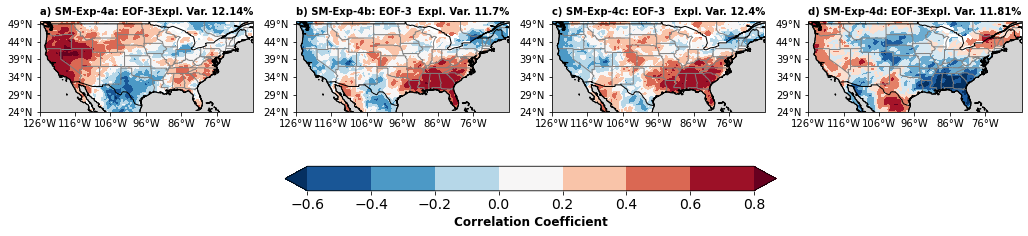

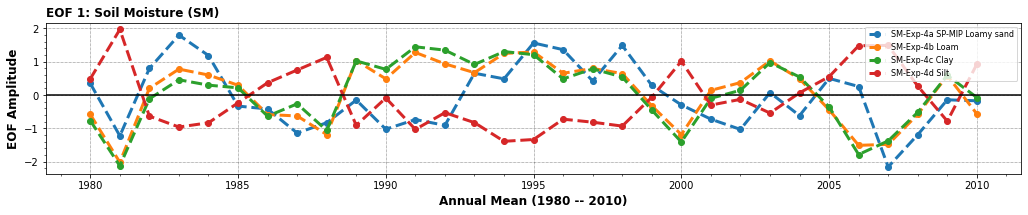

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=[17.6,10], subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'wspace':.2, 'hspace':.22})

#============================================ EOF Spatial Correlation Maps 
# fig.suptitle('Spatially Uniform Soil Paramters', y=0.65,fontweight='bold', fontsize=15)
cs4a = make_contour_plot(eofs_corr4a[2,:,:], var_fracs4a[2], 0, 'a) SM-Exp-4a: EOF-3')
cs4b = make_contour_plot(eofs_corr4b[2,:,:], var_fracs4b[2], 1, 'b) SM-Exp-4b: EOF-3')
cs4c = make_contour_plot(eofs_corr4c[2,:,:], var_fracs4c[2], 2, 'c) SM-Exp-4c: EOF-3')
cs4d = make_contour_plot(eofs_corr4d[2,:,:], var_fracs4d[2], 3, 'd) SM-Exp-4d: EOF-3')
#======================== Create colorbar
cbar = plt.colorbar(cs4a, ax=ax.ravel().tolist(), orientation='horizontal', shrink=.5, extend='both', pad=0.099)
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Correlation Coefficient',fontweight='bold', fontsize=12)
#cbar.set_ticks(np.linspace(eofs_corr3.min(), eofs_corr3.max(), 6))

#============================================ EOF Time Series 
years = np.arange(1980, 2011, 1)
eof_amplitudes = [pcs4a[:,2], pcs4b[:,2], pcs4c[:,2], pcs4d[:,2]]
eof_labels = ["SM-Exp-4a SP-MIP Loamy sand", "SM-Exp-4b Loam", "SM-Exp-4c Clay", "SM-Exp-4d Silt"]
title = "EOF 1: Soil Moisture (SM)"
xlabel = "Annual Mean (1980 -- 2010)"
ylabel = "EOF Amplitude"
_plot_eofs_over_time(years, eof_amplitudes, eof_labels, title, xlabel, ylabel)
